Importamos lo necesario para el Script.

In [1]:
#CIL
from cil.io import NikonDataReader
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector, Binner, AbsorptionTransmissionConverter
from cil.optimisation.functions import IndicatorBox
from cil.optimisation.algorithms import CGLS, SIRT, PDHG
from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer
from cil.optimisation.operators import IdentityOperator
from cil.optimisation.functions import L2NormSquared, L1Norm
#from cil.utilities import dataexample

# TIGRE
from cil.recon import FDK as FDKTigre
from cil.plugins.tigre import ProjectionOperator as ProjectionOperatorTigre
from cil.plugins.tigre import FBP as FBPTigre


# Astra
from cil.plugins.astra.processors import FBP as FBPAstra
from cil.plugins.astra.operators import ProjectionOperator as ProjectionOperatorAstra

# Plugins
from cil.plugins import TomoPhantom

# Otros
import os
import numpy as np
import matplotlib.pyplot as plt
import logging

Guardamos la ruta donde se encuentra nuestro archivo `xtekct` del tomografo Nikon.

In [2]:
filename = "Cili\CS180.xtekct"

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\TalentPC\AppData\Local\Temp\ipykernel_19000\3574950331.py:1: SyntaxWarning: invalid escape sequence '\C'
  filename = "Cili\CS180.xtekct"


In [3]:
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

Para que se puedan leer los datos de entrada, el archivo `xteckt` debe de estar en la misma carpeta que las proyecciones. Para este caso está en la misma carpeta que las 180 imagenes .Tif del cilindro.

In [4]:
data_in = NikonDataReader(file_name=filename).read()

In [5]:
print(data_in)

Number of dimensions: 3
Shape: (180, 499, 500)
Axis labels: ('angle', 'vertical', 'horizontal')



In [6]:
# print the geometry data associated with the data
print(data_in.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.    , -87.9998,   0.    ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  -0.    , 1019.0002,    0.    ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [500 499]
	Pixel size: [0.1 0.1]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-9 in degrees: [174.20728, 172.20728, 170.20726, 168.20724, 166.20723, 164.20721,
 162.2072 , 160.20718, 158.20718, 156.20717]
	Angles 170-179 in degrees: [-165.79492, -167.79495, -169.79495, -171.79498, -173.79498, -175.79501,
 -177.79501, -179.79501, -181.79504, -183.79504]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


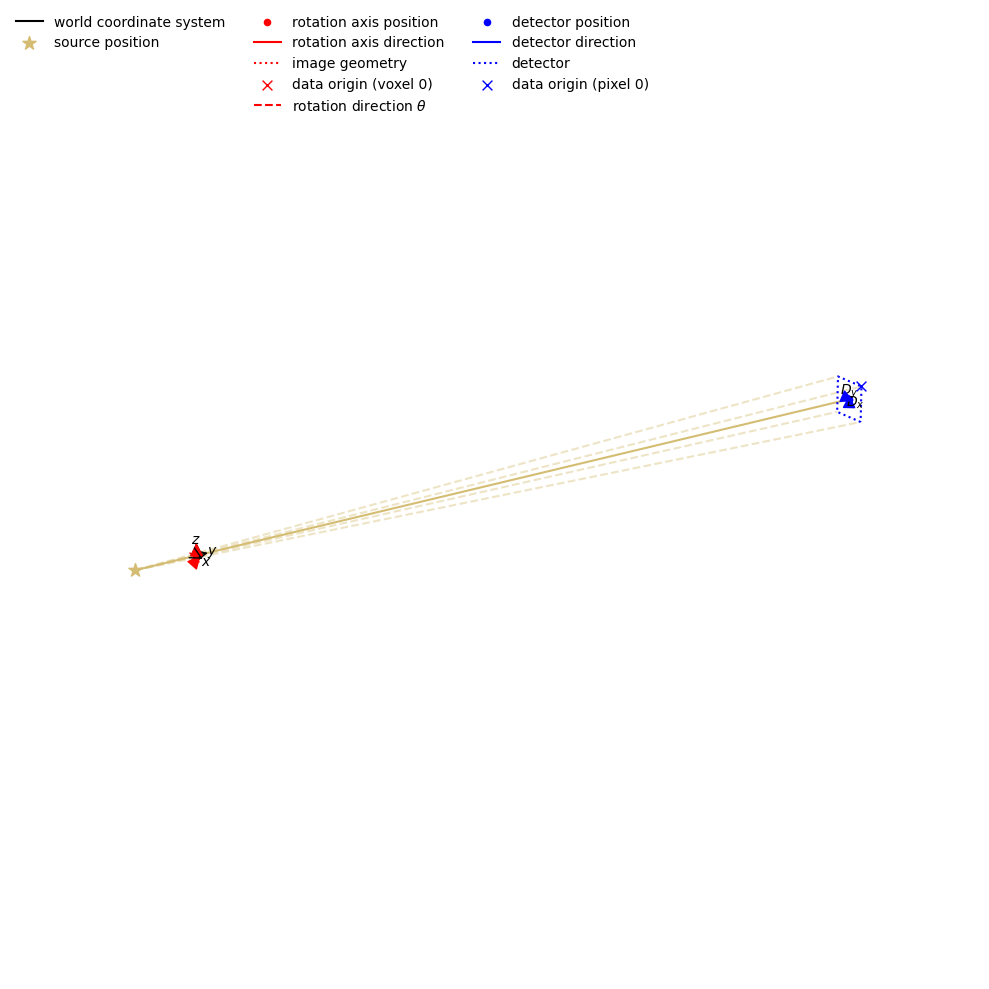

In [7]:
# display the geometry
show_geometry(data_in.geometry, elevation=20, azimuthal=- 35, view_distance=10, figsize=(10, 10), fontsize=10)

In [8]:
islicer(data_in, direction='angle',size=10, origin='upper')

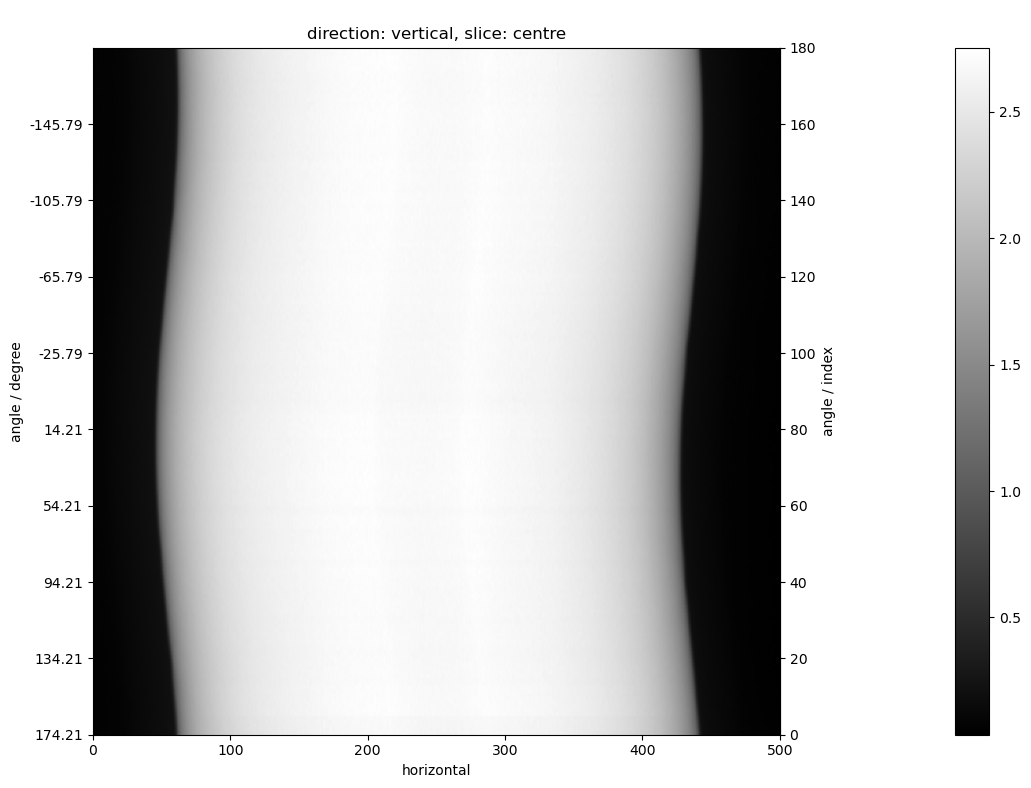

In [8]:
# calculate the absorption data using the Beer–Lambert law
data_absorption = TransmissionAbsorptionConverter()(data_in)

# show the centre slice using show2D
show2D(data_absorption, slice_list=('vertical', 'centre'))

In [9]:
ag = NikonDataReader(file_name=filename).get_geometry()
ig = ag.get_ImageGeometry()

# FDK TIGRE

In [10]:
data_absorption.reorder(order='tigre')
data_centred = CentreOfRotationCorrector.image_sharpness(backend='tigre', search_range=100, tolerance=0.1)(data_absorption)

INFO:cil.processors.CofR_image_sharpness:evaluated 11 points
INFO:cil.processors.CofR_image_sharpness:Centre of rotation correction found using image_sharpness
INFO:cil.processors.CofR_image_sharpness:backend FBP/FDK tigre
INFO:cil.processors.CofR_image_sharpness:Calculated from slice: centre
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 5.324566 pixels
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 0.042327 units at the object
INFO:cil.processors.CofR_image_sharpness:Return new dataset with centred geometry


In [11]:
ag2 = data_centred.geometry
ig2 = ag2.get_ImageGeometry()

In [12]:
# reorder the data for the `tigre` backend
#data_absorption.reorder(order='tigre')

# create the FDK reconstructor
fdk =  FDKTigre(data_centred, ig2)

# run the reconstructor
recon = fdk.run()

FDK recon

Input Data:
	angle: 180
	vertical: 499
	horizontal: 500

Reconstruction Volume:
	vertical: 499
	horizontal_y: 500
	horizontal_x: 500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 10
	Filter_inplace: False



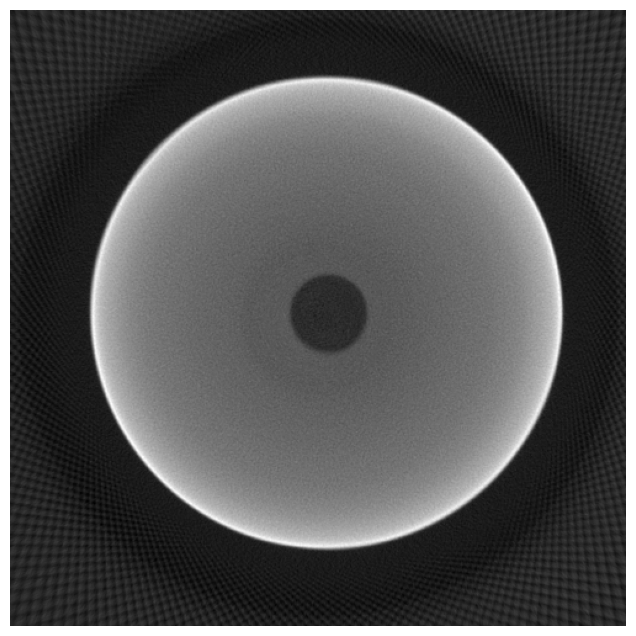

In [15]:
# visualise the 3D reconstructed volume
#islicer(recon, direction='vertical', size=10, cmap="gray") # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions
#show2D(recon, slice_list=[('vertical',20), ('horizontal_x', 50)], fix_range=(-0.01, 0.1))
#show2D(recon, cmap="gray", slice_list=[215])

"""
#Para imprimir igual que los otros algoritmos. (Nota: no tiene el mismo tamanio)
plt.figure(figsize=(8, 8))
plt.imshow(recon.as_array()[430, :, :], cmap="gray")
plt.title("")
plt.axis('off')
"""


# Tamaño en píxeles deseado para obtener imagen igual a los algoritmos.
"""
width_px = 652
height_px = 660
"""

width_px = 800
height_px = 800


# Define el dpi (dots per inch). Puede ser 100, 200, etc. El dpi afecta la calidad de la imagen.
dpi = 100

# Calcula el tamaño en pulgadas
figsize = (width_px / dpi, height_px / dpi)

# Crear la figura con el tamaño calculado y el dpi especificado
plt.figure(figsize=figsize, dpi=dpi)

# Muestra la imagen
plt.imshow(recon.as_array()[430, :, :], cmap="gray")
plt.title("")
plt.axis('off')

# Guarda la imagen en el tamaño deseado
plt.savefig('FDK_430.png', bbox_inches='tight', pad_inches=0)

# Opcionalmente, también puedes mostrar la imagen
plt.show()



# CGLS

In [16]:
# Definir la carpeta de salida
output_dir = 'Imagenes430/CGLS'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Reordenar datos
data_in.reorder('astra')
data_centred.reorder("astra")
ag = data_centred.geometry
ig = ag.get_ImageGeometry()

# Crear el operador de proyección usando Astra-Toolbox
A = ProjectionOperatorAstra(ig, ag, "gpu")

# Configurar CGLS
initial = ig.allocate(0)

# Iterar desde 2 hasta 30, con un incremento de 2
for max_iter in range(2, 51, 2):
    print(f"Ejecutando CGLS con max_iteration = {max_iter}")
    
    # Configurar el objeto CGLS con el número de iteraciones deseado
    cgls = CGLS(initial=initial,
                operator=A,
                data=data_centred,
                max_iteration=max_iter,
                update_objective_interval=1)

    # Ejecutar CGLS
    cgls.run(verbose=True)

    # Obtener la solución
    recon_cgls = cgls.solution
    
    # Mostrar la imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(recon_cgls.as_array()[430, :, :], cmap="gray")
    #plt.title(f'CGLS, Iteraciones: {max_iter}, corte: 215')
    plt.axis('off')
    
    # Guardar la imagen
    filename = os.path.join(output_dir, f'CGLS_{max_iter}.png')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    print(f"Imagen guardada en: {filename}")


Ejecutando CGLS con max_iteration = 2


C:\Users\TalentPC\AppData\Local\Temp\ipykernel_19000\738753259.py:30: DeprecationWarning: `run()` missing `iterations`
  cgls.run(verbose=True)


  0%|          | 0/2 [00:00<?, ?it/s]

Imagen guardada en: prueba\CGLS_2.png
Ejecutando CGLS con max_iteration = 4


  0%|          | 0/4 [00:00<?, ?it/s]

Imagen guardada en: prueba\CGLS_4.png
Ejecutando CGLS con max_iteration = 6


  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

# SIRT

In [14]:
# Definir la carpeta de salida
output_dir = 'Imagenes430/SIRT'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Reordenar datos
data_in.reorder('astra')
data_centred.reorder("astra")
ag = data_centred.geometry
ig = ag.get_ImageGeometry()

# Crear el operador de proyección usando Astra-Toolbox
A = ProjectionOperatorAstra(ig, ag, "gpu")

# Configurar la caja indicadora
constraint = IndicatorBox(lower=0)

# Iterar desde 2 hasta 30, con un incremento de 2
for max_iter in range(2, 51, 2):
    print(f"Ejecutando SIRT con max_iteration = {max_iter}")
    
    # Configurar el objeto SIRT con el número de iteraciones deseado
    sirt = SIRT(initial=ig.allocate(0),
                operator=A,
                data=data_centred,
                constraint=constraint,
                max_iteration=max_iter)
    
    sirt.update_objective_interval = 1

    # Ejecutar SIRT
    sirt.run(verbose=True)

    # Obtener la solución
    recon_sirt_noisy = sirt.solution
    
    # Mostrar y guardar la imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(recon_sirt_noisy.as_array()[430, :, :], cmap="gray")
    #plt.title(f'SIRT, Iteraciones {max_iter}, corte: 215')
    plt.axis('off')
    
    # Guardar la imagen
    filename = os.path.join(output_dir, f'SIRT_{max_iter}.png')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    print(f"Imagen guardada en: {filename}")


Ejecutando SIRT con max_iteration = 2


c:\Users\TalentPC\anaconda3\envs\cil\Lib\site-packages\cil\framework\framework.py:3068: RuntimeWarning: divide by zero encountered in power
  out = pwop(self.as_array() , x2 , *args, **kwargs )
C:\Users\TalentPC\AppData\Local\Temp\ipykernel_2240\2120832170.py:32: DeprecationWarning: `run()` missing `iterations`
  sirt.run(verbose=True)


  0%|          | 0/2 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_2.png
Ejecutando SIRT con max_iteration = 4


  0%|          | 0/4 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_4.png
Ejecutando SIRT con max_iteration = 6


  0%|          | 0/6 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_6.png
Ejecutando SIRT con max_iteration = 8


  0%|          | 0/8 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_8.png
Ejecutando SIRT con max_iteration = 10


  0%|          | 0/10 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_10.png
Ejecutando SIRT con max_iteration = 12


  0%|          | 0/12 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_12.png
Ejecutando SIRT con max_iteration = 14


  0%|          | 0/14 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_14.png
Ejecutando SIRT con max_iteration = 16


  0%|          | 0/16 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_16.png
Ejecutando SIRT con max_iteration = 18


  0%|          | 0/18 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_18.png
Ejecutando SIRT con max_iteration = 20


  0%|          | 0/20 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_20.png
Ejecutando SIRT con max_iteration = 22


  0%|          | 0/22 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_22.png
Ejecutando SIRT con max_iteration = 24


  0%|          | 0/24 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_24.png
Ejecutando SIRT con max_iteration = 26


  0%|          | 0/26 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_26.png
Ejecutando SIRT con max_iteration = 28


  0%|          | 0/28 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_28.png
Ejecutando SIRT con max_iteration = 30


  0%|          | 0/30 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_30.png
Ejecutando SIRT con max_iteration = 32


  0%|          | 0/32 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_32.png
Ejecutando SIRT con max_iteration = 34


  0%|          | 0/34 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_34.png
Ejecutando SIRT con max_iteration = 36


  0%|          | 0/36 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_36.png
Ejecutando SIRT con max_iteration = 38


  0%|          | 0/38 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_38.png
Ejecutando SIRT con max_iteration = 40


  0%|          | 0/40 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_40.png
Ejecutando SIRT con max_iteration = 42


  0%|          | 0/42 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_42.png
Ejecutando SIRT con max_iteration = 44


  0%|          | 0/44 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_44.png
Ejecutando SIRT con max_iteration = 46


  0%|          | 0/46 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_46.png
Ejecutando SIRT con max_iteration = 48


  0%|          | 0/48 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_48.png
Ejecutando SIRT con max_iteration = 50


  0%|          | 0/50 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/SIRT\SIRT_50.png


# PDHG

In [17]:
# Definir la carpeta de salida
output_dir = 'Imagenes430/PDHG'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Reordenar datos
data_in.reorder('astra') 
data_centred.reorder("astra")
ag = data_centred.geometry
ig = ag.get_ImageGeometry()

type(ig)

# Crear el operador de proyección usando Astra-Toolbox
A = ProjectionOperatorAstra(ig, ag, "gpu")


# Definir la función y el operador PDHG
F = 1000 * L2NormSquared(b=data_centred)
G = 0.005 * L1Norm()

# Iterar desde 2 hasta 30, con un incremento de 2
for max_iter in range(2, 51, 2):
    print(f"Ejecutando PDHG con max_iteration = {max_iter}")
    
    # Configurar el objeto PDHG con el número de iteraciones deseado
    pdhg_l1 = PDHG(
        f=F,
        g=G,
        operator=A,
        max_iteration=max_iter,
        update_objective_interval=1
    )

    # Ejecutar PDHG
    pdhg_l1.run(verbose=True)

    # Obtener la solución
    recon_pdhg = pdhg_l1.solution
    
    # Mostrar y guardar la imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(recon_pdhg.as_array()[430, :, :], cmap="gray")
    #plt.title(f'PDHG, Iteraciones {max_iter}, corte: 215')
    plt.axis('off')
    
    # Guardar la imagen
    filename = os.path.join(output_dir, f'PDHG_{max_iter}.png')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    print(f"Imagen guardada en: {filename}")


Ejecutando PDHG con max_iteration = 2


C:\Users\TalentPC\AppData\Local\Temp\ipykernel_19000\2346159044.py:36: DeprecationWarning: `run()` missing `iterations`
  pdhg_l1.run(verbose=True)


  0%|          | 0/2 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_2.png
Ejecutando PDHG con max_iteration = 4


  0%|          | 0/4 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_4.png
Ejecutando PDHG con max_iteration = 6


  0%|          | 0/6 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_6.png
Ejecutando PDHG con max_iteration = 8


  0%|          | 0/8 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_8.png
Ejecutando PDHG con max_iteration = 10


  0%|          | 0/10 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_10.png
Ejecutando PDHG con max_iteration = 12


  0%|          | 0/12 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_12.png
Ejecutando PDHG con max_iteration = 14


  0%|          | 0/14 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_14.png
Ejecutando PDHG con max_iteration = 16


  0%|          | 0/16 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_16.png
Ejecutando PDHG con max_iteration = 18


  0%|          | 0/18 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_18.png
Ejecutando PDHG con max_iteration = 20


  0%|          | 0/20 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_20.png
Ejecutando PDHG con max_iteration = 22


  0%|          | 0/22 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_22.png
Ejecutando PDHG con max_iteration = 24


  0%|          | 0/24 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_24.png
Ejecutando PDHG con max_iteration = 26


  0%|          | 0/26 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_26.png
Ejecutando PDHG con max_iteration = 28


  0%|          | 0/28 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_28.png
Ejecutando PDHG con max_iteration = 30


  0%|          | 0/30 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_30.png
Ejecutando PDHG con max_iteration = 32


  0%|          | 0/32 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_32.png
Ejecutando PDHG con max_iteration = 34


  0%|          | 0/34 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_34.png
Ejecutando PDHG con max_iteration = 36


  0%|          | 0/36 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_36.png
Ejecutando PDHG con max_iteration = 38


  0%|          | 0/38 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_38.png
Ejecutando PDHG con max_iteration = 40


  0%|          | 0/40 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_40.png
Ejecutando PDHG con max_iteration = 42


  0%|          | 0/42 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_42.png
Ejecutando PDHG con max_iteration = 44


  0%|          | 0/44 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_44.png
Ejecutando PDHG con max_iteration = 46


  0%|          | 0/46 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_46.png
Ejecutando PDHG con max_iteration = 48


  0%|          | 0/48 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_48.png
Ejecutando PDHG con max_iteration = 50


  0%|          | 0/50 [00:00<?, ?it/s]

Imagen guardada en: Imagenes430/PDHG\PDHG_50.png


# Perfiles 1D solos y respecto a FDK

## CGLS

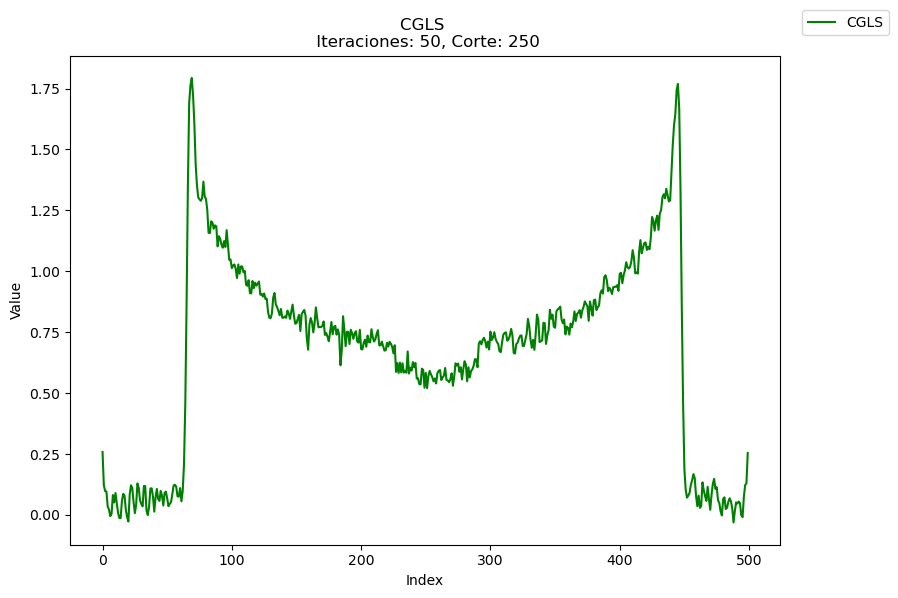

In [17]:
show1D([recon_cgls], title="CGLS \n Iteraciones: 50, Corte: 250", slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["g"], label=["CGLS"])

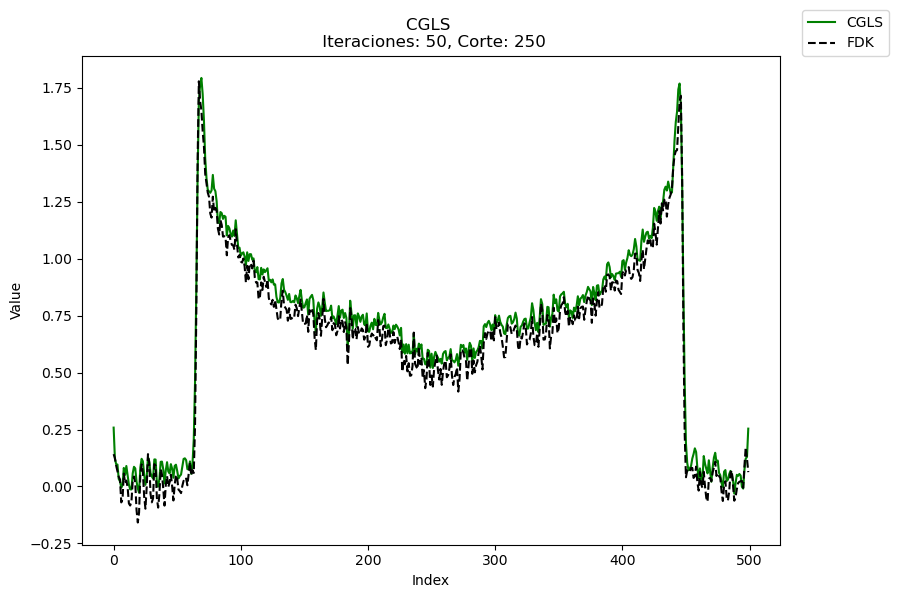

In [19]:
show1D([recon_cgls,recon], title="CGLS \n Iteraciones: 50, Corte: 250", slice_list=[[("horizontal_y",250),("vertical",250)],[("horizontal_y",250),("vertical",250)]], line_colours=["g","k"], label=["CGLS","FDK"])

# SIRT

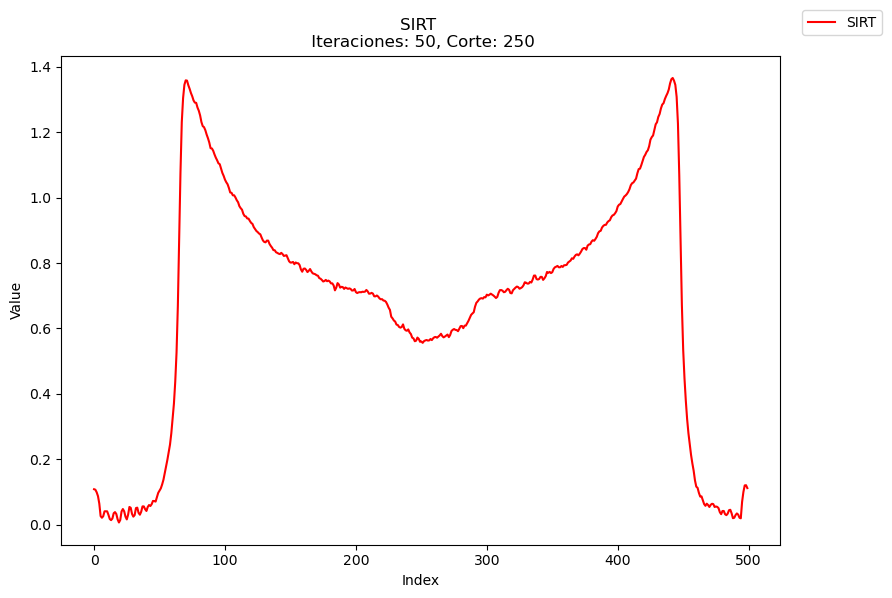

In [18]:
show1D([recon_sirt_noisy], title="SIRT \n Iteraciones: 50, Corte: 250", slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["r"], label=["SIRT"])

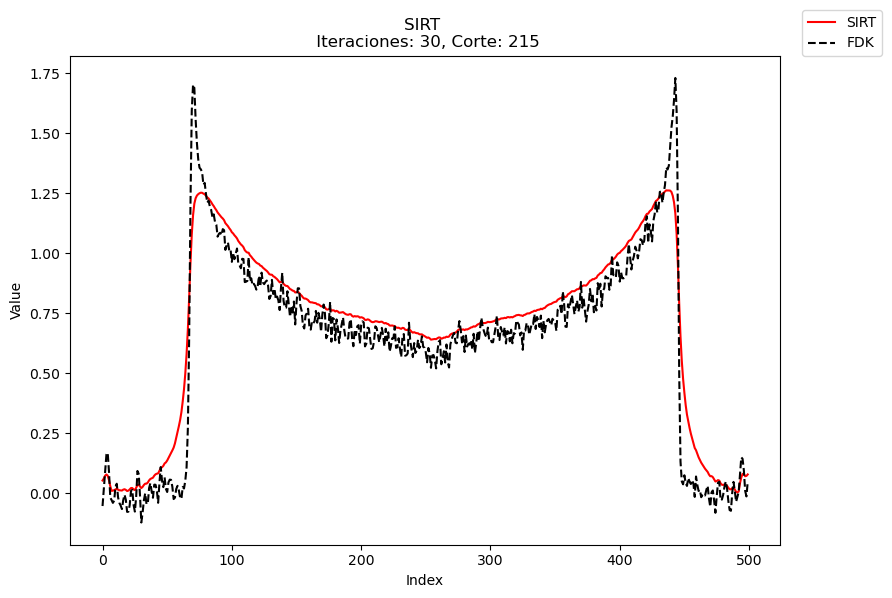

In [19]:
show1D([recon_sirt_noisy,recon], title="SIRT \n Iteraciones: 30, Corte: 215", slice_list=[[("horizontal_y",215),("vertical",215)],[("horizontal_y",215),("vertical",215)]], line_colours=["r","k"], label=["SIRT","FDK"])

# PDHG

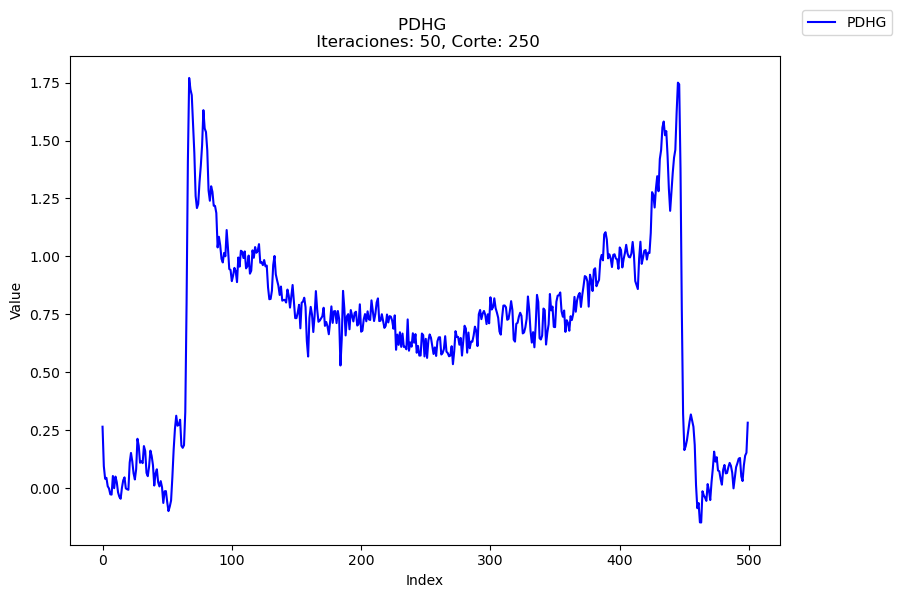

In [18]:
show1D([recon_pdhg], title="PDHG \n Iteraciones: 50, Corte: 250", slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["b"], label=["PDHG"])

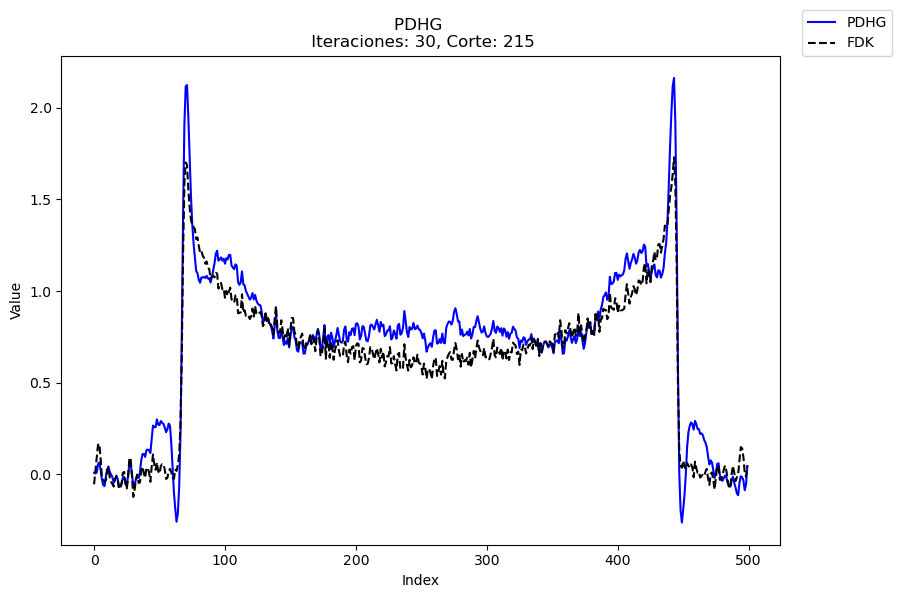

In [21]:
show1D([recon_pdhg,recon], title="PDHG \n Iteraciones: 30, Corte: 215", slice_list=[[("horizontal_y",215),("vertical",215)],[("horizontal_y",215),("vertical",215)]], line_colours=["b","k"], label=["PDHG","FDK"])

# Todos los perfiles

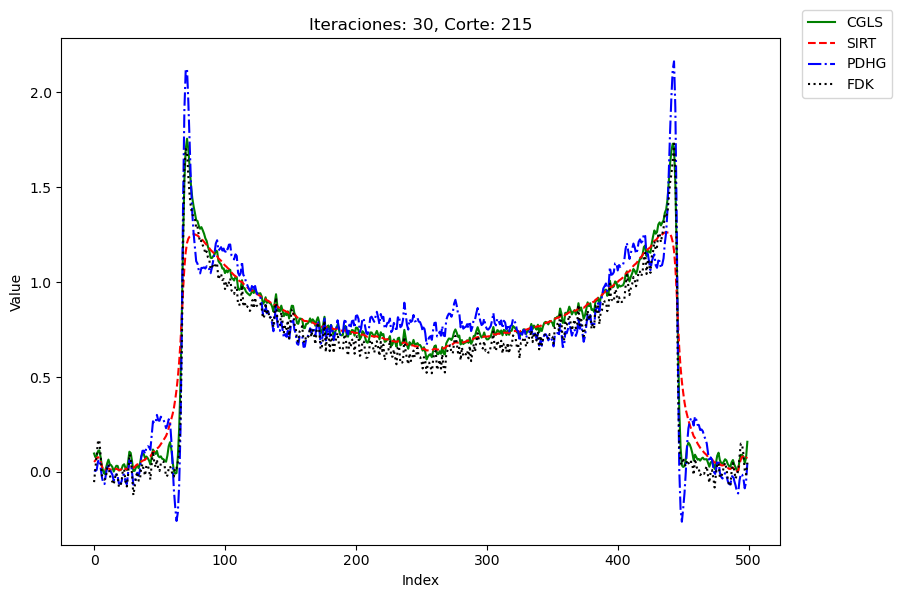

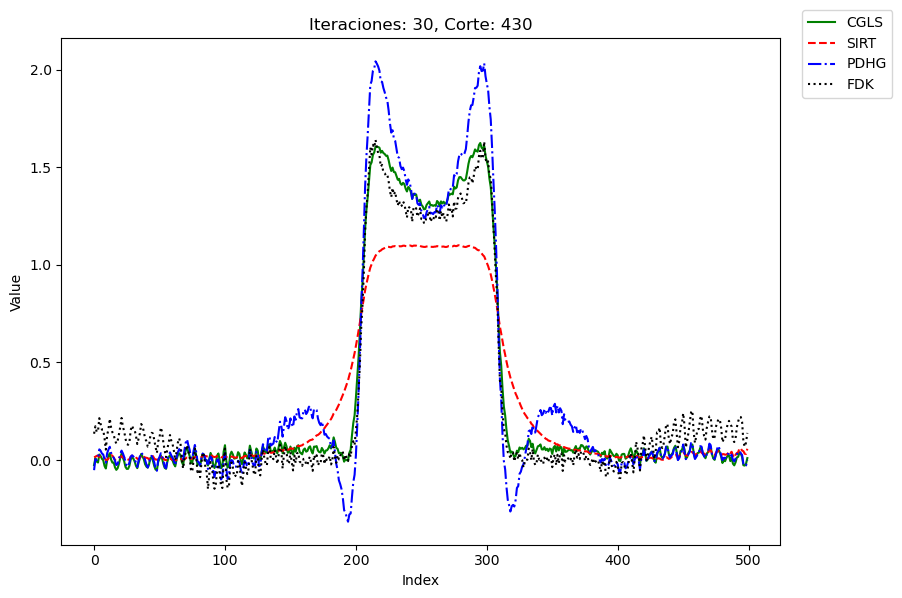

In [23]:
show1D([recon_cgls, recon_sirt_noisy, pdhg_l1.solution, recon], title="Iteraciones: 30, Corte: 215", slice_list=[("horizontal_y",215),("vertical",215)], line_colours=["g","r","b","k"], label=[ "CGLS","SIRT","PDHG","FDK"])
show1D([recon_cgls, recon_sirt_noisy, pdhg_l1.solution, recon], title="Iteraciones: 30, Corte: 430", slice_list=[("horizontal_y",430),("vertical",430)], line_colours=["g","r","b","k"], label=[ "CGLS","SIRT","PDHG","FDK"])